In [19]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
%matplotlib inline

print(tf.__version__)

2.14.0


# Lab 12-0 RNN basics

### Preparing dataset

In [2]:
# One hot encoding for each char in 'hello'
h = [1, 0, 0, 0]
e = [0, 1, 0, 0]
l = [0, 0, 1, 0]
o = [0, 0, 0, 1]

In [3]:
# One cell RNN input_dim (4) -> output_dim (2)
x_data = np.array([[h]], dtype=np.float32)

hidden_size = 2
cell = layers.SimpleRNNCell(units=hidden_size)
rnn = layers.RNN(cell, return_sequences=True, return_state=True)
outputs, states = rnn(x_data)

print('x_data: {}, shape: {}'.format(x_data, x_data.shape))
print('outputs: {}, shape: {}'.format(outputs, outputs.shape))
print('states: {}, shape: {}'.format(states, states.shape))

x_data: [[[1. 0. 0. 0.]]], shape: (1, 1, 4)
outputs: [[[ 0.6220399  -0.45636514]]], shape: (1, 1, 2)
states: [[ 0.6220399  -0.45636514]], shape: (1, 2)


In [4]:
# equivalent to above case
rnn = layers.SimpleRNN(units=hidden_size, return_sequences=True,
                       return_state=True) # layers.SimpleRNNCell + layers.RNN

outputs, states = rnn(x_data)

print('x_data: {}, shape: {}'.format(x_data, x_data.shape))
print('outputs: {}, shape: {}'.format(outputs, outputs.shape))
print('states: {}, shape: {}'.format(states, states.shape))

x_data: [[[1. 0. 0. 0.]]], shape: (1, 1, 4)
outputs: [[[0.16564184 0.4271997 ]]], shape: (1, 1, 2)
states: [[0.16564184 0.4271997 ]], shape: (1, 2)


### Unfolding to n sequences

In [5]:
# One cell RNN input_dim (4) -> output_dim (2). sequence: 5
x_data = np.array([[h, e, l, l, o]], dtype=np.float32)

hidden_size = 2
rnn = layers.SimpleRNN(units=2, return_sequences=True, return_state=True)
outputs, states = rnn(x_data)

print('x_data: {}, shape: {} \n'.format(x_data, x_data.shape))
print('outputs: {}, shape: {} \n'.format(outputs, outputs.shape))
print('states: {}, shape: {}'.format(states, states.shape))

x_data: [[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]], shape: (1, 5, 4) 

outputs: [[[ 0.20401761  0.4798481 ]
  [-0.3352268  -0.8539934 ]
  [-0.56979984  0.90769285]
  [ 0.37455532  0.07364048]
  [ 0.5283787   0.27479172]]], shape: (1, 5, 2) 

states: [[0.5283787  0.27479172]], shape: (1, 2)


### Batching input

In [6]:
# One cell RNN input_dim (4) -> output_dim (2). sequence: 5, batch 3
x_data = np.array([[h, e, l, l, o],
                   [e, o, l, l, l],
                   [l, l, e, e, l]], dtype=np.float32)

hidden_size = 2
rnn = layers.SimpleRNN(units=2, return_sequences=True, return_state=True)
outputs, states = rnn(x_data)

print('x_data: {}, shape: {} \n'.format(x_data, x_data.shape))
print('outputs: {}, shape: {} \n'.format(outputs, outputs.shape))
print('states: {}, shape: {}'.format(states, states.shape))

x_data: [[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]], shape: (3, 5, 4) 

outputs: [[[ 0.5512991   0.40168622]
  [ 0.79069376  0.41693395]
  [ 0.5670397  -0.6739208 ]
  [ 0.12559107 -0.9472396 ]
  [ 0.6299098  -0.87202823]]

 [[ 0.40726516  0.20754153]
  [ 0.86964154 -0.30026084]
  [ 0.47806492 -0.91023844]
  [-0.02465386 -0.96449465]
  [-0.4798205  -0.95788634]]

 [[-0.22798507 -0.76144594]
  [-0.57964426 -0.9313164 ]
  [-0.3648563  -0.48067278]
  [-0.05128737 -0.14916405]
  [-0.31189084 -0.8106027 ]]], shape: (3, 5, 2) 

states: [[ 0.6299098  -0.87202823]
 [-0.4798205  -0.95788634]
 [-0.31189084 -0.8106027 ]], shape: (3, 2)


# Lab 12-1 Many to One

### Preparing dataset

In [7]:
# example data
words = ['good', 'bad', 'worse', 'so good']
y_data = [1,0,0,1]

# creating a token dictionary
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


In [8]:
# converting sequence of tokens to sequence of indices
x_data = list(map(lambda word : [char2idx.get(char) for char in word], words))
x_data_len = list(map(lambda word : len(word), x_data))

print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


In [9]:
# padding the sequence of indices
max_sequence = 10
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence, padding = 'post', truncating = 'post')

print(x_data)
print(x_data_len)
print(y_data)

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]
[4, 3, 5, 7]
[1, 0, 0, 1]


### Creating model

In [10]:
# creating simple rnn for "many to one" classification
input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))
hidden_size = 10
num_classes = 2

model = Sequential()
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                           trainable=False, mask_zero=True, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.SimpleRNN(units=hidden_size))
model.add(layers.Dense(units=num_classes))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 11)            121       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 10)                220       
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 363 (1.42 KB)
Trainable params: 242 (968.00 Byte)
Non-trainable params: 121 (484.00 Byte)
_________________________________________________________________


### Training model

In [12]:
# creating loss function
def loss_fn(model, x, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True))

# creating an optimizer
lr = .01
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [13]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(buffer_size = 4)
tr_dataset = tr_dataset.batch(batch_size = batch_size)

print(tr_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [14]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0

    for x_mb, y_mb in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)

    if (epoch + 1) % 5 ==0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss.numpy()))

epoch :   5, tr_loss : 0.229
epoch :  10, tr_loss : 0.049
epoch :  15, tr_loss : 0.017
epoch :  20, tr_loss : 0.009
epoch :  25, tr_loss : 0.006
epoch :  30, tr_loss : 0.005


### Checking performance

In [15]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('acc : {:.2%}'.format(np.mean(yhat == y_data)))

1/1 [==============================] - 0s 200ms/step
acc : 100.00%


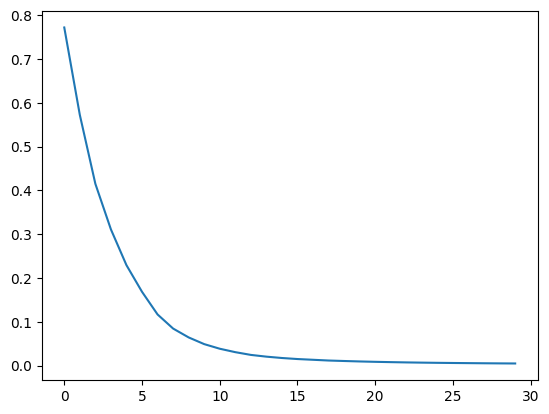

In [18]:
plt.plot(tr_loss_hist)

# Lab 12-2 Many to One Stacking

### Preparing dataset

In [20]:
# example data
sentences = ['What I cannot create, I do not understand.',
             'Intellecuals solve problems, geniuses prevent them',
             'A person who never made a mistake never tied anything new.',
             'The same equations have the same solutions.']
y_data = [1,0,0,1]

In [21]:
# creating a token dictionary
char_set = ['<pad>'] + sorted(list(set(''.join(sentences))))
idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', ',', '.', 'A', 'I', 'T', 'W', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y']
{0: '<pad>', 1: ' ', 2: ',', 3: '.', 4: 'A', 5: 'I', 6: 'T', 7: 'W', 8: 'a', 9: 'b', 10: 'c', 11: 'd', 12: 'e', 13: 'g', 14: 'h', 15: 'i', 16: 'k', 17: 'l', 18: 'm', 19: 'n', 20: 'o', 21: 'p', 22: 'q', 23: 'r', 24: 's', 25: 't', 26: 'u', 27: 'v', 28: 'w', 29: 'y'}
{'<pad>': 0, ' ': 1, ',': 2, '.': 3, 'A': 4, 'I': 5, 'T': 6, 'W': 7, 'a': 8, 'b': 9, 'c': 10, 'd': 11, 'e': 12, 'g': 13, 'h': 14, 'i': 15, 'k': 16, 'l': 17, 'm': 18, 'n': 19, 'o': 20, 'p': 21, 'q': 22, 'r': 23, 's': 24, 't': 25, 'u': 26, 'v': 27, 'w': 28, 'y': 29}


In [22]:
# converting sequence of tokens to sequence of indices
x_data = list(map(lambda sentence : [char2idx.get(char) for char in sentence], sentences))
x_data_len = list(map(lambda sentence : len(sentence), sentences))

print(x_data)
print(x_data_len)
print(y_data)

[[7, 14, 8, 25, 1, 5, 1, 10, 8, 19, 19, 20, 25, 1, 10, 23, 12, 8, 25, 12, 2, 1, 5, 1, 11, 20, 1, 19, 20, 25, 1, 26, 19, 11, 12, 23, 24, 25, 8, 19, 11, 3], [5, 19, 25, 12, 17, 17, 12, 10, 26, 8, 17, 24, 1, 24, 20, 17, 27, 12, 1, 21, 23, 20, 9, 17, 12, 18, 24, 2, 1, 13, 12, 19, 15, 26, 24, 12, 24, 1, 21, 23, 12, 27, 12, 19, 25, 1, 25, 14, 12, 18], [4, 1, 21, 12, 23, 24, 20, 19, 1, 28, 14, 20, 1, 19, 12, 27, 12, 23, 1, 18, 8, 11, 12, 1, 8, 1, 18, 15, 24, 25, 8, 16, 12, 1, 19, 12, 27, 12, 23, 1, 25, 15, 12, 11, 1, 8, 19, 29, 25, 14, 15, 19, 13, 1, 19, 12, 28, 3], [6, 14, 12, 1, 24, 8, 18, 12, 1, 12, 22, 26, 8, 25, 15, 20, 19, 24, 1, 14, 8, 27, 12, 1, 25, 14, 12, 1, 24, 8, 18, 12, 1, 24, 20, 17, 26, 25, 15, 20, 19, 24, 3]]
[42, 50, 58, 43]
[1, 0, 0, 1]


In [23]:
# padding the sequence of indices
max_sequence = 55
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence,
                       padding = 'post', truncating = 'post')

# checking data
print(x_data)
print(x_data_len)
print(y_data)

[[ 7 14  8 25  1  5  1 10  8 19 19 20 25  1 10 23 12  8 25 12  2  1  5  1
  11 20  1 19 20 25  1 26 19 11 12 23 24 25  8 19 11  3  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 5 19 25 12 17 17 12 10 26  8 17 24  1 24 20 17 27 12  1 21 23 20  9 17
  12 18 24  2  1 13 12 19 15 26 24 12 24  1 21 23 12 27 12 19 25  1 25 14
  12 18  0  0  0  0  0]
 [ 4  1 21 12 23 24 20 19  1 28 14 20  1 19 12 27 12 23  1 18  8 11 12  1
   8  1 18 15 24 25  8 16 12  1 19 12 27 12 23  1 25 15 12 11  1  8 19 29
  25 14 15 19 13  1 19]
 [ 6 14 12  1 24  8 18 12  1 12 22 26  8 25 15 20 19 24  1 14  8 27 12  1
  25 14 12  1 24  8 18 12  1 24 20 17 26 25 15 20 19 24  3  0  0  0  0  0
   0  0  0  0  0  0  0]]
[42, 50, 58, 43]
[1, 0, 0, 1]


### Creating model

In [24]:
# creating stacked rnn for "many to one" classification with dropout
num_classes = 2
hidden_dims = [10,10]

input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))

model = Sequential()
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                           trainable=False, mask_zero=True, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.SimpleRNN(units=hidden_dims[0], return_sequences=True))
model.add(layers.TimeDistributed(layers.Dropout(rate = .2)))
model.add(layers.SimpleRNN(units=hidden_dims[1]))
model.add(layers.Dropout(rate = .2))
model.add(layers.Dense(units=num_classes))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 55, 30)            900       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 55, 10)            410       
                                                                 
 time_distributed (TimeDist  (None, 55, 10)            0         
 ributed)                                                        
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                      

### Training model

In [26]:
# creating loss function
def loss_fn(model, x, y, training):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x, training), from_logits=True))

# creating and optimizer
lr = .01
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [27]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size=batch_size)

print(tr_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 55), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [28]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0

    for x_mb, y_mb in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, training=True)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)

    if (epoch + 1) % 5 ==0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss.numpy()))

epoch :   5, tr_loss : 0.411
epoch :  10, tr_loss : 0.099
epoch :  15, tr_loss : 0.035
epoch :  20, tr_loss : 0.096
epoch :  25, tr_loss : 0.004
epoch :  30, tr_loss : 0.002


### Checking performance

In [ ]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('accuracy : {:.2%}'.format(np.mean(yhat == y_data)))

In [ ]:
plt.plot(tr_loss_hist)

# Lab 12-3 Many to Many

### Prepairing dataset

In [29]:
# example data
sentences = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
pos = [['pronoun', 'verb', 'adjective'],
     ['noun', 'verb', 'adverb', 'adjective'],
     ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
     ['noun', 'verb', 'adverb', 'adjective', 'verb']]

### Preprocessing dataset

In [30]:
# creating a token dictionary for word
word_list = sum(sentences, [])
word_list = sorted(set(word_list))
word_list = ['<pad>'] + word_list
word2idx = {word : idx for idx, word in enumerate(word_list)}
idx2word = {idx : word for idx, word in enumerate(word_list)}

print(word2idx)
print(idx2word)
print(len(idx2word))

{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}
15


In [31]:
# creating a token dictionary for part of speech
pos_list = sum(pos, [])
pos_list = sorted(set(pos_list))
pos_list = ['<pad>'] + pos_list
pos2idx = {pos : idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx : pos for idx, pos in enumerate(pos_list)}

print(pos2idx)
print(idx2pos)
print(len(pos2idx))

{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}
8


In [32]:
# converting sequence of tokens to sequence of indices
max_sequence = 10
x_data = list(map(lambda sentence : [word2idx.get(token) for token in sentence], sentences))
y_data = list(map(lambda sentence : [pos2idx.get(token) for token in sentence], pos))

# padding the sequence of indices
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence, padding='post')
x_data_mask = ((x_data != 0) * 1).astype(np.float32)
x_data_len = list(map(lambda sentence : len(sentence), sentences))

y_data = pad_sequences(sequences = y_data, maxlen = max_sequence, padding='post')

print(x_data, x_data_len)
print(x_data_mask)
print(y_data)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]] [3, 4, 7, 5]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


### Creating model

In [33]:
# creating rnn for "many to many" sequence tagging
num_classes = len(pos2idx)
hidden_dim = 10

input_dim = len(word2idx)
output_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

model = Sequential()
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True, trainable=False, input_length=max_sequence, embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.SimpleRNN(units=hidden_dim, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(units=num_classes)))

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 15)            225       
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 10, 10)            260       
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 8)             88        
 stributed)                                                      
                                                                 
Total params: 573 (2.24 KB)
Trainable params: 348 (1.36 KB)
Non-trainable params: 225 (900.00 Byte)
_________________________________________________________________


### Training model

In [35]:
# creating loss function
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    valid_time_step = tf.cast(x_len,dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True) * masking
    sequence_loss = tf.reduce_sum(sequence_loss, axis=-1) / valid_time_step
    sequence_loss = tf.reduce_mean(sequence_loss)
    return sequence_loss

# creating and optimizer
lr = 0.1
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [36]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size = 2)

print(tr_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [37]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0

    for x_mb, y_mb, x_mb_len in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, x_len=x_mb_len, max_sequence=max_sequence)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)

    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   5, tr_loss : 0.131
epoch :  10, tr_loss : 0.009
epoch :  15, tr_loss : 0.002
epoch :  20, tr_loss : 0.001
epoch :  25, tr_loss : 0.001
epoch :  30, tr_loss : 0.001


### Checking performance

In [38]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1) * x_data_mask

pprint(list(map(lambda row : [idx2pos.get(elm) for elm in row],yhat.astype(np.int32).tolist())), width = 120)
pprint(pos)

1/1 [==============================] - 0s 186ms/step
[['pronoun', 'verb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


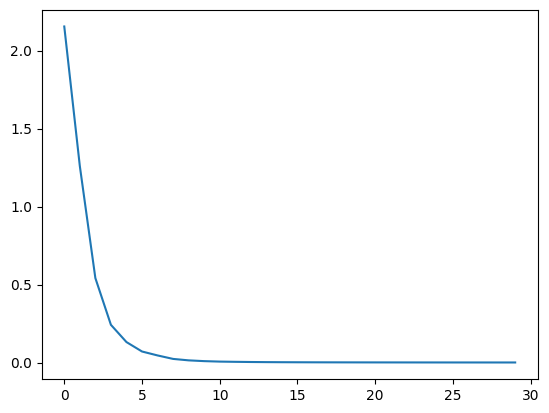

In [39]:
plt.plot(tr_loss_hist)

# Lab 12-4 Many to Many Variable Bidirectional

### Preparing dataset

In [40]:
# example data
sentences = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
pos = [['pronoun', 'verb', 'adjective'],
     ['noun', 'verb', 'adverb', 'adjective'],
     ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
     ['noun', 'verb', 'adverb', 'adjective', 'verb']]

### Preprocessing dataset

In [41]:
# creating a token dictionary for word
word_list = sum(sentences, [])
word_list = sorted(set(word_list))
word_list = ['<pad>'] + word_list
word2idx = {word : idx for idx, word in enumerate(word_list)}
idx2word = {idx : word for idx, word in enumerate(word_list)}

print(word2idx)
print(idx2word)
print(len(idx2word))

{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}
15


In [42]:
# creating a token dictionary for part of speech
pos_list = sum(pos, [])
pos_list = sorted(set(pos_list))
pos_list = ['<pad>'] + pos_list
pos2idx = {pos : idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx : pos for idx, pos in enumerate(pos_list)}

print(pos2idx)
print(idx2pos)
print(len(pos2idx))

{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}
8


In [43]:
# converting sequence of tokens to sequence of indices
max_sequence = 10
x_data = list(map(lambda sentence : [word2idx.get(token) for token in sentence], sentences))
y_data = list(map(lambda sentence : [pos2idx.get(token) for token in sentence], pos))

# padding the sequence of indices
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence, padding='post')
x_data_mask = ((x_data != 0) * 1).astype(np.float32)
x_data_len = list(map(lambda sentence : len(sentence), sentences))

y_data = pad_sequences(sequences = y_data, maxlen = max_sequence, padding='post')

print(x_data, x_data_len)
print(x_data_mask)
print(y_data)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]] [3, 4, 7, 5]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


### Creating model

In [44]:
# creating bidirectional rnn for "many to many" sequence tagging
num_classes = len(pos2idx)
hidden_dim = 10

input_dim = len(word2idx)
output_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

model = Sequential()
model.add(layers.InputLayer(input_shape=(max_sequence,)))
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True, trainable=False, input_length=max_sequence, embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.Bidirectional(keras.layers.SimpleRNN(units=hidden_dim, return_sequences=True)))
model.add(layers.TimeDistributed(keras.layers.Dense(units=num_classes)))

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 15)            225       
                                                                 
 bidirectional (Bidirection  (None, 10, 20)            520       
 al)                                                             
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 8)             168       
 stributed)                                                      
                                                                 
Total params: 913 (3.57 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 225 (900.00 Byte)
_________________________________________________________________


### Training model

In [46]:
# creating loss function
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    valid_time_step = tf.cast(x_len,dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True) * masking
    sequence_loss = tf.reduce_sum(sequence_loss, axis=-1) / valid_time_step
    sequence_loss = tf.reduce_mean(sequence_loss)
    return sequence_loss

# creating and optimizer
lr = 0.1
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [47]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size = 2)

print(tr_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [48]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0

    for x_mb, y_mb, x_mb_len in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, x_len=x_mb_len, max_sequence=max_sequence)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)

    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   5, tr_loss : 0.010
epoch :  10, tr_loss : 0.001
epoch :  15, tr_loss : 0.000
epoch :  20, tr_loss : 0.000
epoch :  25, tr_loss : 0.000
epoch :  30, tr_loss : 0.000


### Checking performance

In [49]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1) * x_data_mask

pprint(list(map(lambda row : [idx2pos.get(elm) for elm in row],yhat.astype(np.int32).tolist())), width = 120)
pprint(pos)

1/1 [==============================] - 0s 383ms/step
[['pronoun', 'verb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


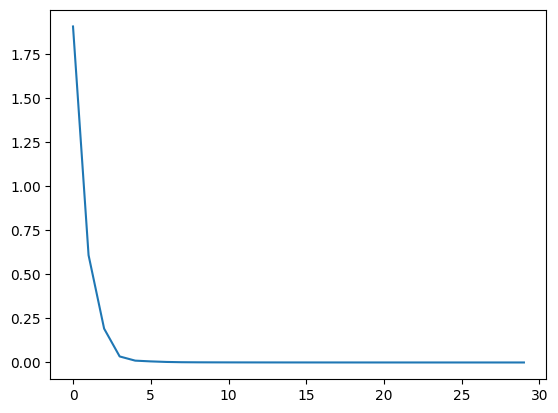

In [50]:
plt.plot(tr_loss_hist)

# Lab 12-5 Sequence to Sequence

In [51]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from matplotlib import font_manager, rc

rc('font', family='AppleGothic') #for mac

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pprint import pprint
import numpy as np
import os

print(tf.__version__)

2.14.0


In [52]:
sources = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
targets = [['나는', '배가', '고프다'],
           ['텐서플로우는', '매우', '어렵다'],
           ['텐서플로우는', '딥러닝을', '위한', '프레임워크이다'],
           ['텐서플로우는', '매우', '빠르게', '변화한다']]

In [53]:
# vocabulary for sources
s_vocab = list(set(sum(sources, [])))
s_vocab.sort()
s_vocab = ['<pad>'] + s_vocab
source2idx = {word : idx for idx, word in enumerate(s_vocab)}
idx2source = {idx : word for idx, word in enumerate(s_vocab)}

pprint(source2idx)

{'<pad>': 0,
 'I': 1,
 'a': 2,
 'changing': 3,
 'deep': 4,
 'difficult': 5,
 'fast': 6,
 'feel': 7,
 'for': 8,
 'framework': 9,
 'hungry': 10,
 'is': 11,
 'learning': 12,
 'tensorflow': 13,
 'very': 14}


In [54]:
# vocabulary for targets
t_vocab = list(set(sum(targets, [])))
t_vocab.sort()
t_vocab = ['<pad>', '<bos>', '<eos>'] + t_vocab
target2idx = {word : idx for idx, word in enumerate(t_vocab)}
idx2target = {idx : word for idx, word in enumerate(t_vocab)}

pprint(target2idx)

{'<bos>': 1,
 '<eos>': 2,
 '<pad>': 0,
 '고프다': 3,
 '나는': 4,
 '딥러닝을': 5,
 '매우': 6,
 '배가': 7,
 '변화한다': 8,
 '빠르게': 9,
 '어렵다': 10,
 '위한': 11,
 '텐서플로우는': 12,
 '프레임워크이다': 13}


In [55]:
def preprocess(sequences, max_len, dic, mode = 'source'):
    assert mode in ['source', 'target'], 'source와 target 중에 선택해주세요.'

    if mode == 'source':
        # preprocessing for source (encoder)
        s_input = list(map(lambda sentence : [dic.get(token) for token in sentence], sequences))
        s_len = list(map(lambda sentence : len(sentence), s_input))
        s_input = pad_sequences(sequences = s_input, maxlen = max_len, padding = 'post', truncating = 'post')
        return s_len, s_input

    elif mode == 'target':
        # preprocessing for target (decoder)
        # input
        t_input = list(map(lambda sentence : ['<bos>'] + sentence + ['<eos>'], sequences))
        t_input = list(map(lambda sentence : [dic.get(token) for token in sentence], t_input))
        t_len = list(map(lambda sentence : len(sentence), t_input))
        t_input = pad_sequences(sequences = t_input, maxlen = max_len, padding = 'post', truncating = 'post')

        # output
        t_output = list(map(lambda sentence : sentence + ['<eos>'], sequences))
        t_output = list(map(lambda sentence : [dic.get(token) for token in sentence], t_output))
        t_output = pad_sequences(sequences = t_output, maxlen = max_len, padding = 'post', truncating = 'post')

        return t_len, t_input, t_output

In [56]:
# preprocessing for source
s_max_len = 10
s_len, s_input = preprocess(sequences = sources,
                            max_len = s_max_len, dic = source2idx, mode = 'source')
print(s_len, s_input)

[3, 4, 7, 5] [[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]


In [57]:
# preprocessing for target
t_max_len = 12
t_len, t_input, t_output = preprocess(sequences = targets,
                                      max_len = t_max_len, dic = target2idx, mode = 'target')
print(t_len, t_input, t_output)

[5, 5, 6, 6] [[ 1  4  7  3  2  0  0  0  0  0  0  0]
 [ 1 12  6 10  2  0  0  0  0  0  0  0]
 [ 1 12  5 11 13  2  0  0  0  0  0  0]
 [ 1 12  6  9  8  2  0  0  0  0  0  0]] [[ 4  7  3  2  0  0  0  0  0  0  0  0]
 [12  6 10  2  0  0  0  0  0  0  0  0]
 [12  5 11 13  2  0  0  0  0  0  0  0]
 [12  6  9  8  2  0  0  0  0  0  0  0]]


### hyper-param

In [58]:
# hyper-parameters
epochs = 200
batch_size = 4
learning_rate = .005
total_step = epochs / batch_size
buffer_size = 100
n_batch = buffer_size//batch_size
embedding_dim = 32
units = 32

# input
data = tf.data.Dataset.from_tensor_slices((s_len, s_input, t_len, t_input, t_output))
data = data.shuffle(buffer_size = buffer_size)
data = data.batch(batch_size = batch_size)

In [59]:
def gru(units):
    return tf.keras.layers.GRU(units,
                               return_sequences=True,
                               return_state=True,
                               recurrent_initializer='glorot_uniform')

In [60]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)

        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [61]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden, enc_output):

        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [62]:
encoder = Encoder(len(source2idx), embedding_dim, units, batch_size)
decoder = Decoder(len(target2idx), embedding_dim, units, batch_size)

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask

    return tf.reduce_mean(loss_)

# creating optimizer
optimizer = tf.keras.optimizers.Adam()

# creating check point (Object-based saving)
checkpoint_dir = './data_out/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [63]:
for epoch in range(epochs):

    hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for i, (s_len, s_input, t_len, t_input, t_output) in enumerate(data):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(s_input, hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([target2idx['<bos>']] * batch_size, 1)

            for t in range(1, t_input.shape[1]):
                predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(t_input[:, t], predictions)
                dec_input = tf.expand_dims(t_input[:, t], 1) #using teacher forcing

        batch_loss = (loss / int(t_input.shape[1]))
        total_loss += batch_loss
        variables = encoder.variables + decoder.variables
        gradient = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradient, variables))

    if epoch % 10 == 0:
        print('Epoch {} Loss {:.4f} Batch Loss {:.4f}'.format(epoch, total_loss / n_batch, batch_loss.numpy()))
        checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 0 Loss 0.0396 Batch Loss 0.9912
Epoch 10 Loss 0.0387 Batch Loss 0.9686
Epoch 20 Loss 0.0375 Batch Loss 0.9377
Epoch 30 Loss 0.0353 Batch Loss 0.8828
Epoch 40 Loss 0.0313 Batch Loss 0.7816
Epoch 50 Loss 0.0282 Batch Loss 0.7047
Epoch 60 Loss 0.0251 Batch Loss 0.6286
Epoch 70 Loss 0.0222 Batch Loss 0.5542
Epoch 80 Loss 0.0192 Batch Loss 0.4801
Epoch 90 Loss 0.0163 Batch Loss 0.4068
Epoch 100 Loss 0.0135 Batch Loss 0.3370
Epoch 110 Loss 0.0110 Batch Loss 0.2741
Epoch 120 Loss 0.0089 Batch Loss 0.2216
Epoch 130 Loss 0.0072 Batch Loss 0.1808
Epoch 140 Loss 0.0060 Batch Loss 0.1508
Epoch 150 Loss 0.0052 Batch Loss 0.1299
Epoch 160 Loss 0.0046 Batch Loss 0.1156
Epoch 170 Loss 0.0042 Batch Loss 0.1058
Epoch 180 Loss 0.0039 Batch Loss 0.0987
Epoch 190 Loss 0.0037 Batch Loss 0.0935


In [64]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [65]:
sentence = 'I feel hungry'

In [ ]:
def prediction(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):

    inputs = [inp_lang[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang['<bos>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out)

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += idx2target[predicted_id] + ' '

        if idx2target.get(predicted_id) == '<eos>':
            return result, sentence

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

result, output_sentence = prediction(sentence, encoder, decoder, source2idx, target2idx, s_max_len, t_max_len)

print(sentence)
print(result)

# Lab 12-6 Sequence to Sequence with attention

In [133]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pprint import pprint
import numpy as np
import os

print(tf.__version__)

2.14.0


In [72]:
sources = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
targets = [['나는', '배가', '고프다'],
           ['텐서플로우는', '매우', '어렵다'],
           ['텐서플로우는', '딥러닝을', '위한', '프레임워크이다'],
           ['텐서플로우는', '매우', '빠르게', '변화한다']]

In [73]:
# vocabulary for sources
s_vocab = list(set(sum(sources, [])))
s_vocab.sort()
s_vocab = ['<pad>'] + s_vocab
source2idx = {word : idx for idx, word in enumerate(s_vocab)}
idx2source = {idx : word for idx, word in enumerate(s_vocab)}

pprint(source2idx)

{'<pad>': 0,
 'I': 1,
 'a': 2,
 'changing': 3,
 'deep': 4,
 'difficult': 5,
 'fast': 6,
 'feel': 7,
 'for': 8,
 'framework': 9,
 'hungry': 10,
 'is': 11,
 'learning': 12,
 'tensorflow': 13,
 'very': 14}


In [74]:
# vocabulary for targets
t_vocab = list(set(sum(targets, [])))
t_vocab.sort()
t_vocab = ['<pad>', '<bos>', '<eos>'] + t_vocab
target2idx = {word : idx for idx, word in enumerate(t_vocab)}
idx2target = {idx : word for idx, word in enumerate(t_vocab)}

pprint(target2idx)

{'<bos>': 1,
 '<eos>': 2,
 '<pad>': 0,
 '고프다': 3,
 '나는': 4,
 '딥러닝을': 5,
 '매우': 6,
 '배가': 7,
 '변화한다': 8,
 '빠르게': 9,
 '어렵다': 10,
 '위한': 11,
 '텐서플로우는': 12,
 '프레임워크이다': 13}


In [75]:
def preprocess(sequences, max_len, dic, mode = 'source'):
    assert mode in ['source', 'target'], 'source와 target 중에 선택해주세요.'

    if mode == 'source':
        s_input = list(map(lambda sentence : [dic.get(token) for token in sentence], sequences))
        s_len = list(map(lambda sentence : len(sentence), s_input))
        s_input = pad_sequences(sequences = s_input, maxlen = max_len, padding = 'post', truncating = 'post')
        return s_len, s_input

    elif mode == 'target':
        t_input = list(map(lambda sentence : ['<bos>'] + sentence + ['<eos>'], sequences))
        t_input = list(map(lambda sentence : [dic.get(token) for token in sentence], t_input))
        t_len = list(map(lambda sentence : len(sentence), t_input))
        t_input = pad_sequences(sequences = t_input, maxlen = max_len, padding = 'post', truncating = 'post')

        t_output = list(map(lambda sentence : sentence + ['<eos>'], sequences))
        t_output = list(map(lambda sentence : [dic.get(token) for token in sentence], t_output))
        t_output = pad_sequences(sequences = t_output, maxlen = max_len, padding = 'post', truncating = 'post')

        return t_len, t_input, t_output

In [76]:
# preprocessing for source
s_max_len = 10
s_len, s_input = preprocess(sequences = sources,
                            max_len = s_max_len, dic = source2idx, mode = 'source')
print(s_len, s_input)

[3, 4, 7, 5] [[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]


In [77]:
# preprocessing for target
t_max_len = 12
t_len, t_input, t_output = preprocess(sequences = targets, max_len = t_max_len, dic = target2idx, mode = 'target')
print(t_len, t_input, t_output)

[5, 5, 6, 6] [[ 1  4  7  3  2  0  0  0  0  0  0  0]
 [ 1 12  6 10  2  0  0  0  0  0  0  0]
 [ 1 12  5 11 13  2  0  0  0  0  0  0]
 [ 1 12  6  9  8  2  0  0  0  0  0  0]] [[ 4  7  3  2  0  0  0  0  0  0  0  0]
 [12  6 10  2  0  0  0  0  0  0  0  0]
 [12  5 11 13  2  0  0  0  0  0  0  0]
 [12  6  9  8  2  0  0  0  0  0  0  0]]


### hyper-param

In [78]:
# hyper-parameters
epochs = 100
batch_size = 4
learning_rate = .005
total_step = epochs / batch_size
buffer_size = 100
n_batch = buffer_size//batch_size
embedding_dim = 32
units = 128

# input
data = tf.data.Dataset.from_tensor_slices((s_len, s_input, t_len, t_input, t_output))
data = data.shuffle(buffer_size = buffer_size)
data = data.batch(batch_size = batch_size)

In [79]:
def gru(units):
    return tf.keras.layers.GRU(units,
                               return_sequences=True,
                               return_state=True,
                               recurrent_activation='sigmoid',
                               recurrent_initializer='glorot_uniform')

In [80]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)

        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [82]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, x, hidden, enc_output):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [83]:
encoder = Encoder(len(source2idx), embedding_dim, units, batch_size)
decoder = Decoder(len(target2idx), embedding_dim, units, batch_size)

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask

    return tf.reduce_mean(loss_)

# creating optimizer
optimizer = tf.keras.optimizers.Adam()

# creating check point (Object-based saving)
checkpoint_dir = './data_out/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                encoder=encoder,
                                decoder=decoder)

# create writer for tensorboard
summary_writer = tf.summary.create_file_writer(logdir=checkpoint_dir)

In [84]:
for epoch in range(epochs):

    hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for i, (s_len, s_input, t_len, t_input, t_output) in enumerate(data):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(s_input, hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([target2idx['<bos>']] * batch_size, 1)

            for t in range(1, t_input.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(t_input[:, t], predictions)
                dec_input = tf.expand_dims(t_input[:, t], 1) #using teacher forcing

        batch_loss = (loss / int(t_input.shape[1]))
        total_loss += batch_loss
        variables = encoder.variables + decoder.variables
        gradient = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradient, variables))

    if epoch % 10 == 0:
        print('Epoch {} Loss {:.4f} Batch Loss {:.4f}'.format(epoch, total_loss / n_batch, batch_loss.numpy()))
        checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 0 Loss 0.0396 Batch Loss 0.9890
Epoch 10 Loss 0.0377 Batch Loss 0.9428
Epoch 20 Loss 0.0344 Batch Loss 0.8592
Epoch 30 Loss 0.0328 Batch Loss 0.8200
Epoch 40 Loss 0.0303 Batch Loss 0.7563
Epoch 50 Loss 0.0241 Batch Loss 0.6019
Epoch 60 Loss 0.0173 Batch Loss 0.4313
Epoch 70 Loss 0.0127 Batch Loss 0.3171
Epoch 80 Loss 0.0074 Batch Loss 0.1846
Epoch 90 Loss 0.0041 Batch Loss 0.1019


In [85]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = [inp_lang[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang['<bos>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += idx2target[predicted_id] + ' '

        if idx2target.get(predicted_id) == '<eos>':
            return result, sentence, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


In [86]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [87]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [88]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<ipython-input-86-219babc300ac>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-86-219babc300ac>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py

Input: I feel hungry
Predicted translation: 나는 배가 고프다 <eos> 


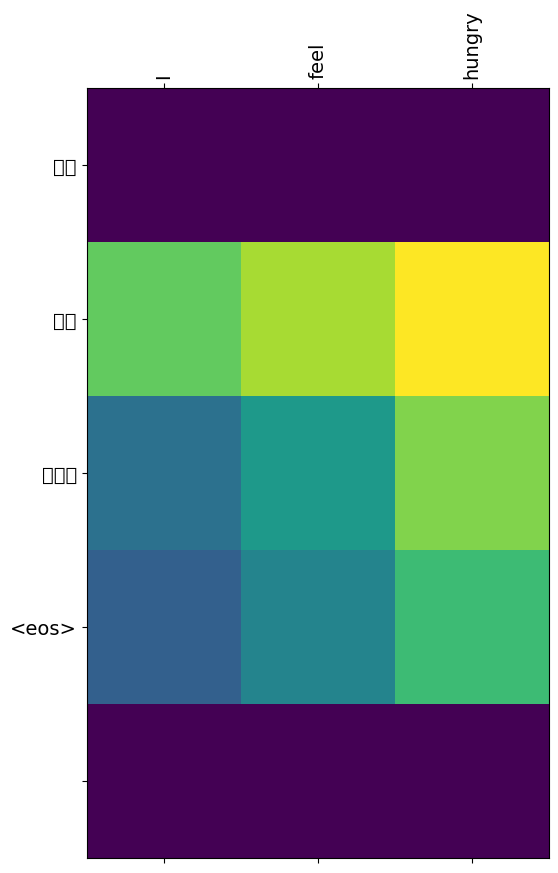

In [89]:
sentence = 'I feel hungry'

translate(sentence, encoder, decoder, source2idx, target2idx, s_max_len, t_max_len)

# Lab 12-7 Sequence to Sequence with attention chatbot

In [123]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

2.14.0


In [103]:
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
g++ set to manually installed.
The following additional packages will be installed:

In [104]:
from konlpy.tag import Twitter
import pandas as pd
import enum
import os
import re
from sklearn.model_selection import train_test_split
import numpy as np

In [116]:
def loadData():
    dataDF = pd.read_csv('/content/ChatBotData.csv', header=0)
    question, answer = list(dataDF['Q']), list(dataDF['A'])
    return question, answer

def preproLikeMorphlized(data):
    morphAnalyzer = Twitter()
    result_data = list()

    for seq in data:
        morphlizedSeq = " ".join(morphAnalyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlizedSeq)

    return result_data

def dataTokenizer(data):
    words = []
    for sentence in data:
        sentence = re.sub(change_filter, "", sentence)
        for word in sentence.split():
            words.append(word)
    return [word for word in words if word]

def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>'

    return w

def create_dataset(data, num_examples):
    word_pairs = [[preprocess_sentence(l)]  for l in data[:num_examples]]
    return word_pairs

class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx['<pad>'] = 0

        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(path, num_examples):
    data_df = pd.read_csv(path, header=0)
    question, answer = list(data_df['Q']), list(data_df['A'])
    question = create_dataset(question, num_examples)
    answer = create_dataset(answer, num_examples)

    print(len(question))

    pairs = [question[i] + answer[i] for i in range(num_examples)]
    inp_lang = LanguageIndex(q for q, a in pairs)
    targ_lang = LanguageIndex(a for q, a in pairs)
    input_tensor = [[inp_lang.word2idx[s] for s in q.split(' ')] for q, a in pairs]
    target_tensor = [[targ_lang.word2idx[s] for s in a.split(' ')] for q, a in pairs]
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')

    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

num_examples = 11823

input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset('/content/ChatBotData.csv', num_examples)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

11823


(9458, 9458, 2365, 2365)

### Create a tf.dataset

In [117]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [118]:
def gru(units):
    return tf.keras.layers.GRU(units,
                               return_sequences=True,
                               return_state=True,
                               recurrent_activation='sigmoid',
                               recurrent_initializer='glorot_uniform')

In [119]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        print("state: {}".format(state.shape))
        print("output: {}".format(state.shape))

        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [120]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, x, hidden, enc_output):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [121]:
print(vocab_inp_size, vocab_tar_size, embedding_dim, units, BATCH_SIZE)

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

13422 9856 256 1024 64


### Define the optimizer and the loss function

In [125]:
optimizer = tf.keras.optimizers.legacy.Adam()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask

    return tf.reduce_mean(loss_)

### Checkpoints (Object-based saving)

In [126]:
checkpoint_dir = './data_out/training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training

In [127]:
EPOCHS = 1

for epoch in range(EPOCHS):
    start = time.time()

    hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0

        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)

            for t in range(1, targ.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(targ[:, t], predictions)
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

    if (epoch + 1) % 2 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

state: (64, 1024)
output: (64, 1024)
Epoch 1 Batch 0 Loss 1.9893
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64

In [128]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [129]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [130]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

<ipython-input-129-219babc300ac>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-129-219babc300ac>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47952 (\N{HANGUL SYLLABLE MWEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.p

state: (1, 1024)
output: (1, 1024)
Input: <start> 뭐라도 배워볼까 . <end>
Predicted translation: . . <end> 


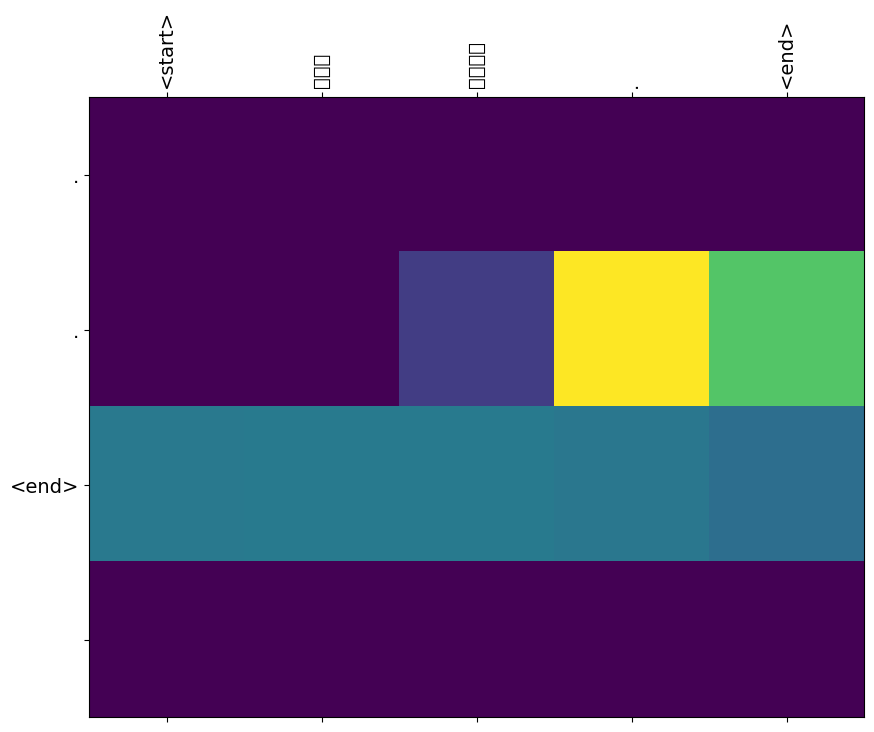

In [132]:
translate('뭐라도 배워볼까.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)